---
title: "motivation"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

This is the temperature for the Yatir Forest (Shani station, see [map](https://maps.app.goo.gl/JXfHcjE2Vn8YbS91A){target="_blank"}), between 2 and 5 of January 2022.
Data is in intervals of 10 minutes, and was downloaded from the Israel Meteorological Service.

In [16]:
#| code-summary: "import stuff"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import datetime as dt
import matplotlib.ticker as ticker
import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)  # white graphs, with large and legible letters
import requests
import json
import os
# %matplotlib widget

In [17]:
#| code-summary: "API to download data from IMS"
# read token from file
with open('../archive/IMS-token.txt', 'r') as file:
    TOKEN = file.readline()
# 28 = SHANI station
STATION_NUM = 28
start = "2022/01/01"
end = "2022/01/07"
filename = 'shani_2022_january.json'

# check if the JSON file already exists
# if so, then load file
if os.path.exists(filename):
    with open(filename, 'r') as json_file:
        data = json.load(json_file)
else:
    # make the API request if the file doesn't exist
    url = f"https://api.ims.gov.il/v1/envista/stations/{STATION_NUM}/data/?from={start}&to={end}"
    headers = {'Authorization': f'ApiToken {TOKEN}'}
    response = requests.get(url, headers=headers)
    data = json.loads(response.text.encode('utf8'))
    
    # save the JSON data to a file
    with open(filename, 'w') as json_file:
        json.dump(data, json_file)
# show data to see if it's alright
# data

In [18]:
#| code-summary: "load data and pre process it"
df = pd.json_normalize(data['data'],record_path=['channels'], meta=['datetime'])
df['date'] = (pd.to_datetime(df['datetime'])
                .dt.tz_localize(None)  # ignores time zone information
             )
df = df.pivot(index='date', columns='name', values='value')
# df

In [6]:
#| code-summary: "useful dirty trick"
# dirty trick to have dates in the middle of the 24-hour period
# make minor ticks in the middle, put the labels there!
# from https://matplotlib.org/stable/gallery/ticks/centered_ticklabels.html

def centered_dates(ax):
    date_form = DateFormatter("%d %b")  # %d 3-letter-Month
    # major ticks at midnight, every day
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    # minor ticks at noon, every day
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[12]))
    # erase major tick labels
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    # set minor tick labels as define above
    ax.xaxis.set_minor_formatter(date_form)
    # completely erase minor ticks, center tick labels
    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('center')

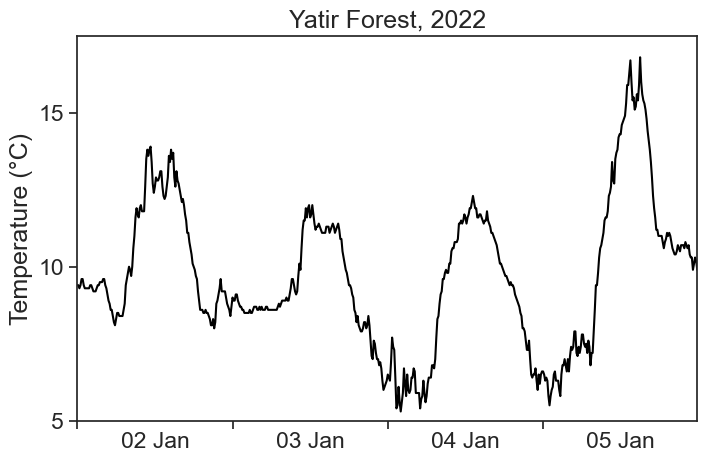

In [14]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8,5))
start = "2022-01-02"
end = "2022-01-05"
df = df.loc[start:end]
ax.plot(df['TD'], color='black')
ax.set(ylim=[5, 17.5],
       xlim=[df.index[0], df.index[-1]],
       ylabel="Temperature (°C)",
       title="Yatir Forest, 2022",
       yticks=[5,10,15])
centered_dates(ax)
fig.savefig("YF-temperature_2022_jan.png", dpi=300)

We see that the temperature curve has a rough profile.
Can we find ways of getting smoother curves?

We learned how to average over a window with `resample`. Let's try that for a 2-hour window:

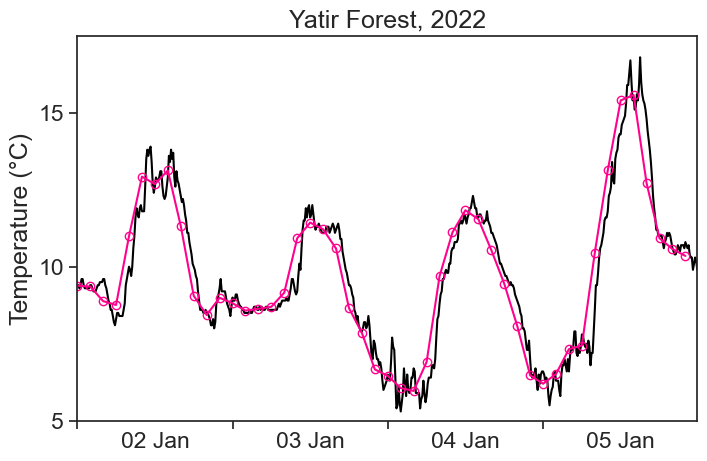

In [15]:
#| code-summary: "plot with 2-hour resampled average"
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(df['TD'], color='black')
ax.plot(df['TD'].resample('2H').mean(),
        color='xkcd:hot pink', ls='-',
        marker="o", mfc="None")
ax.set(ylim=[5, 17.5],
       xlim=[df.index[0], df.index[-1]],
       ylabel="Temperature (°C)",
       title="Yatir Forest, 2022",
       yticks=[5,10,15])
centered_dates(ax)

The temperature profile now is much smoother, but when using `resample`, we lost temporal resolution. Our original data had 10-minute frequency, and now we have a 2-hour frequency.

How can we get a smoother curve without losing resolution?

## Tumbling vs Sliding

![Source: https://docs.wavefront.com/query_language_windows_trends.html](5sec_tumbling_window.png)
![Source: https://docs.wavefront.com/query_language_windows_trends.html](5sec_moving_window.png)